In [1]:
import argparse
import logging
import numpy as np
import pyvista as pv

from pathlib import Path
from pointcept.supplemental.utils import disable_trame_logger
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    process_folds,
    plot_mesh_folds,
    persist_best_iteration,
    load_best_iteration,
    crop_meshes_per_fold,
    save_splits
)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

label = 'rog_south'

set_data_root("../../data")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler(label)
dh.ensure_meshes()

22:30:23 - INFO - Label rog_south already has extracted meshes.


In [3]:
analyser = MeshAnalyser(data_handler=dh)

In [4]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

22:30:25 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP', '13_OTHER'].
22:30:25 - INFO - Sampling with resolution 0.15.
22:30:26 - INFO - Number of points after initial sampling: 5515655
22:30:28 - INFO - Number of points after Poisson Disk Sampling: 481633
22:30:28 - INFO - Number of points after initial sampling: 696084
22:30:29 - INFO - Number of points after Poisson Disk Sampling: 140256
22:30:29 - INFO - Number of points after initial sampling: 378012
22:30:29 - INFO - Number of points after Poisson Disk Sampling: 44007
22:30:29 - INFO - Number of points after initial sampling: 1553631
22:30:30 - INFO - Number of points after Poisson Disk Sampling: 83679
22:30:30 - INFO - Number of points after initial sampling: 750448
22:30:30 - INFO - Number of points after Poisson Disk Sampling: 145095
22:30:30 - INFO - Number of points after initial sampling: 38353

In [20]:
binning = analyser.evaluate_binning(pcds, x_cell_width=7.0, y_cell_width=7.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

22:39:30 - INFO - Binning is using 7 bins in X and 14 bins in Y based on cell widths of 7.0 and 7.0.


22:42:16 - INFO - New best equality score: 4058042.7111 at iteration 1
22:42:16 - INFO - New best equality score: 4048872.1111 at iteration 2
22:42:16 - INFO - New best equality score: 1044734.8971 at iteration 12
22:42:16 - INFO - New best equality score: 68614.8277 at iteration 24
22:42:16 - INFO - New best equality score: 28626.9064 at iteration 28
22:42:17 - INFO - New best equality score: 26120.3053 at iteration 293
22:42:17 - INFO - New best equality score: 24047.0823 at iteration 669
22:42:18 - INFO - 
Best equality score after 1000 iterations: 24047.0823
22:42:18 - INFO - Best iteration: 669
22:42:18 - INFO - 
Final category counts and percentages per area:

Area 1:
  Area size: 28 cells (28.57% of total, intended 25.00%)
  1_WALL: 91169 points (18.93% ± 0.06% of total 1_WALL)
  2_FLOOR: 24078 points (17.17% ± 0.10% of total 2_FLOOR)
  3_ROOF: 8522 points (19.37% ± 0.19% of total 3_ROOF)
  4_CEILING: 14796 points (17.68% ± 0.13% of total 4_CEILING)
  5_FOOTPATH: 45483 points (3

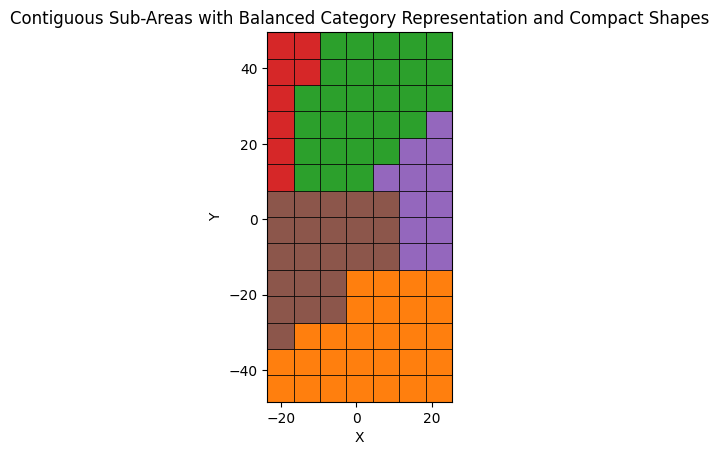

In [29]:
weights = [0.25, 0.3, 0.1, 0.1, 0.15]  # Intended area weights: training, evaluation, test
iterations = 1000  # Number of iterations to run
min_percentage_threshold = 6  # Minimum acceptable percentage per category per area
verbose = True  # Whether to print detailed statistics

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    min_percentage_threshold=min_percentage_threshold,
    verbose=verbose
)

# Run the algorithm
grid_splitter.run(random_seed=6495386943)

# Plot the result
grid_splitter.plot()

Processing Fold 1
Fold 1 has 3 rectangles with total perimeter 34.


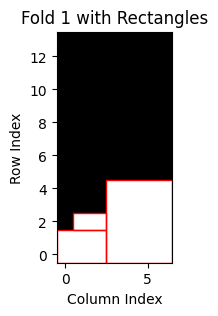

Processing Fold 2
Fold 2 has 5 rectangles with total perimeter 44.


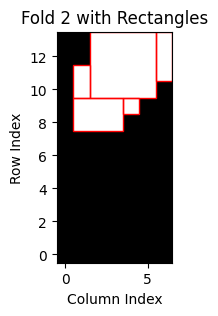

Processing Fold 3
Fold 3 has 2 rectangles with total perimeter 20.


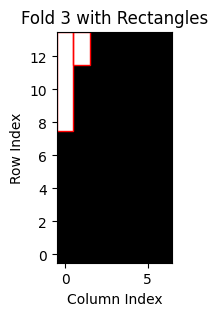

Processing Fold 4
Fold 4 has 3 rectangles with total perimeter 22.


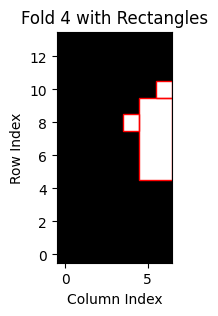

Processing Fold 5
Fold 5 has 3 rectangles with total perimeter 30.


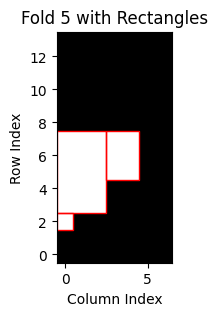

In [30]:
# Process the folds and get the rectangles
fold_rectangles = process_folds(grid_splitter.best_grid)

In [31]:
fname_schema = f'{label}_3fold.pkl'
persist_best_iteration(gridsplitter=grid_splitter, fold_rectangles=fold_rectangles, filename=fname_schema)

Data from the best iteration has been saved to rog_south_3fold.pkl


In [32]:
loaded_data = load_best_iteration(fname_schema)

22:42:26 - INFO - Best Iteration: 669
22:42:26 - INFO - Best Equality Score: 24047.0823
22:42:26 - INFO - 
Final category counts per area:

Area 1:
  Area size: 28 cells (28.57% of total, intended 25.00%)
  1_WALL: 91169 points (18.93% of total 1_WALL)
  2_FLOOR: 24078 points (17.17% of total 2_FLOOR)
  3_ROOF: 8522 points (19.37% of total 3_ROOF)
  4_CEILING: 14796 points (17.68% of total 4_CEILING)
  5_FOOTPATH: 45483 points (31.35% of total 5_FOOTPATH)
  7_COLUMN: 830 points (27.42% of total 7_COLUMN)
  8_DOOR: 1357 points (6.36% of total 8_DOOR)
  9_WINDOW: 870 points (7.50% of total 9_WINDOW)
  10_STAIR: 926 points (11.72% of total 10_STAIR)
  11_RAILING: 3703 points (18.29% of total 11_RAILING)
  12_RWP: 138 points (6.81% of total 12_RWP)
  13_OTHER: 5746 points (20.98% of total 13_OTHER)
  Total points in area: 197618

Area 2:
  Area size: 28 cells (28.57% of total, intended 30.00%)
  1_WALL: 247948 points (51.48% of total 1_WALL)
  2_FLOOR: 86656 points (61.78% of total 2_FLOOR

Data from rog_south_3fold.pkl has been loaded successfully.


In [33]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    loaded_data['fold_rectangles'],
    loaded_data['x_edges'],
    loaded_data['y_edges']
)

22:42:27 - INFO - Processing Fold 1
22:42:36 - INFO - Processing Fold 2
22:42:47 - INFO - Processing Fold 3
22:42:52 - INFO - Processing Fold 4
22:42:54 - INFO - Processing Fold 5


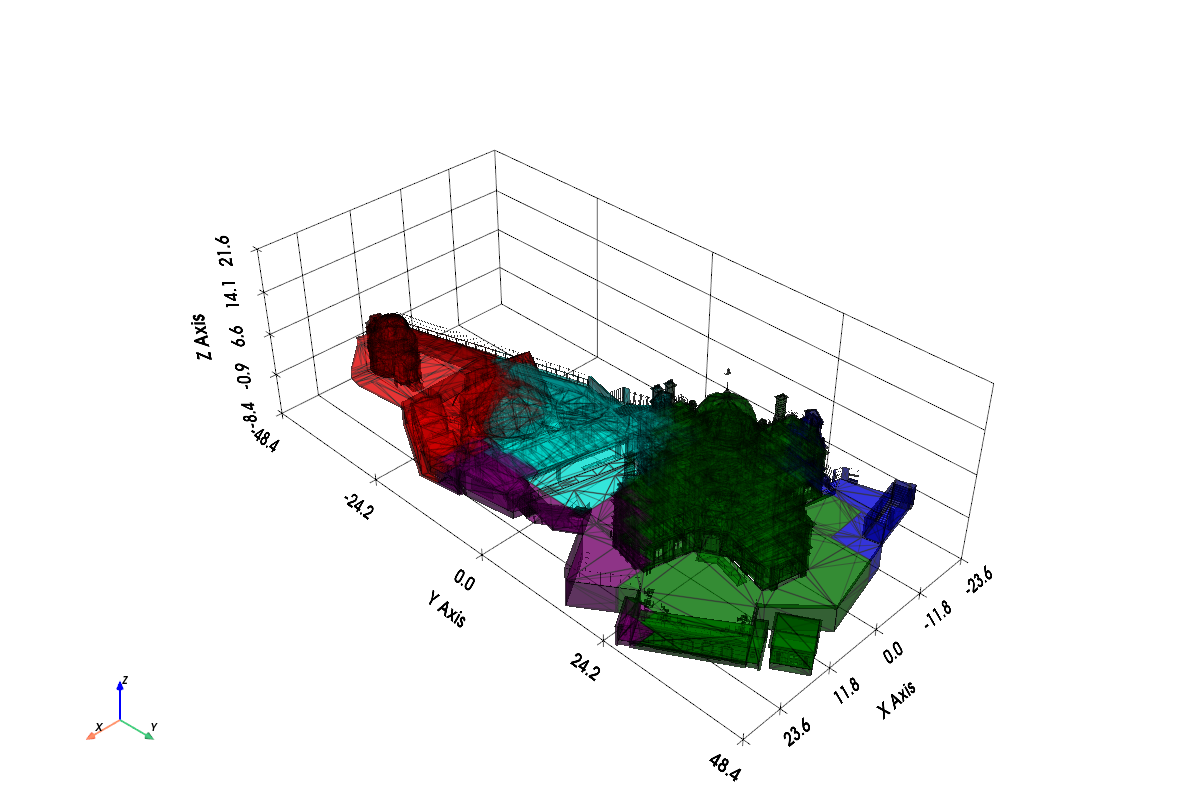

In [34]:
plot_mesh_folds(fold_meshes)

In [27]:
fold_name_map = {
    1: 'train',
    2: 'test',
    3: 'eval',
}

fold_meshes_2 = {fold_name_map[k]: v for k, v in fold_meshes.items()}

In [28]:
save_splits(dh, fold_meshes_2)

22:40:36 - INFO - Fold train, category 1_WALL saved.
22:40:36 - INFO - Fold train, category 2_FLOOR saved.
22:40:36 - INFO - Fold train, category 3_ROOF saved.
22:40:36 - INFO - Fold train, category 4_CEILING saved.
22:40:36 - INFO - Fold train, category 5_FOOTPATH saved.
22:40:36 - INFO - Fold train, category 7_COLUMN saved.
22:40:36 - INFO - Fold train, category 8_DOOR saved.
22:40:36 - INFO - Fold train, category 9_WINDOW saved.
22:40:36 - INFO - Fold train, category 10_STAIR saved.
22:40:37 - INFO - Fold train, category 11_RAILING saved.
22:40:37 - INFO - Fold train, category 12_RWP saved.
22:40:37 - INFO - Fold train, category 13_OTHER saved.
22:40:37 - INFO - Fold test, category 1_WALL saved.
22:40:37 - INFO - Fold test, category 2_FLOOR saved.
22:40:37 - INFO - Fold test, category 3_ROOF saved.
22:40:37 - INFO - Fold test, category 4_CEILING saved.
22:40:37 - INFO - Fold test, category 5_FOOTPATH saved.
22:40:37 - INFO - Fold test, category 7_COLUMN saved.
22:40:37 - INFO - Fold

In [17]:
dh.generate_and_save_fold_clouds(resolution=0.02, poisson_radius=0.05, save_all_formats=True)

22:32:46 - INFO - Number of points after initial sampling: 96200054
22:33:23 - INFO - Number of points after Poisson Disk Sampling: 1987297
22:33:25 - INFO - Saving cloud as .las format...
22:33:28 - INFO - Saved as: ../../data/clouds/res0.02_pr0.05/rog_south/train/1_wall.las
22:33:28 - INFO - Saved point cloud to ../../data/clouds/res0.02_pr0.05/rog_south/train/1_wall.pth in .pth format.
22:33:29 - INFO - Number of points after initial sampling: 22791503
22:33:37 - INFO - Number of points after Poisson Disk Sampling: 639363
22:33:37 - INFO - Saving cloud as .las format...
22:33:38 - INFO - Saved as: ../../data/clouds/res0.02_pr0.05/rog_south/train/2_floor.las
22:33:38 - INFO - Saved point cloud to ../../data/clouds/res0.02_pr0.05/rog_south/train/2_floor.pth in .pth format.
22:33:39 - INFO - Number of points after initial sampling: 5835982
22:33:40 - INFO - Number of points after Poisson Disk Sampling: 133437
22:33:41 - INFO - Saving cloud as .las format...
22:33:41 - INFO - Saved as: 